In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn
import os
from datetime import datetime, timedelta
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input, TimeDistributed, LeakyReLU, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,TensorBoard

/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sprkzoff/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
os.listdir('./data/')

['DJI_ema.csv',
 'DJI_STO_20period_sma10.csv',
 'DJI_modified_sma.csv',
 '.DS_Store',
 'DJI_modified_features - DJI.csv',
 'nk_fe.csv',
 'DJI_fe.csv',
 'N225withoutNULL.csv',
 'dowjone1985_2019.csv',
 'N225fillVOL.csv',
 'test_djia.csv',
 'DJI_denoise.csv',
 'N225.csv',
 'stocknews',
 'preprocessed',
 'downjone5y.csv']

In [3]:
df_nikkei = pd.read_csv('./data/N225withoutNULL.csv')
df_djia = pd.read_csv('./data/DJI_modified_sma.csv')

In [4]:
df_nikkei.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0
3,1985-02-01,11946.959961,11946.959961,11946.959961,11946.959961,11946.959961,0
4,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0


In [5]:
df_djia['Date'][0]

'1985-01-29'

# Preprocess

In [6]:
# postpone 1 day and concatenate both table

# decrement datetime of djia first
df_djia_dc = df_djia.copy()
# df_djia_dc['Date'] = df_djia['Date'] + timedelta(days=-1)
for i in tqdm(range(len(df_djia))):
    df_djia_dc['Date'][i] = str((datetime.strptime(df_djia.iloc[i]['Date'], '%Y-%m-%d') + timedelta(days=-1)).date())

# df_djia_dc.head()
df = pd.merge(df_nikkei, df_djia_dc, on='Date', how='inner')
df = df.rename({'Open_x': 'Open(Nikkei)', 'High_x': 'High(Nikkei)', 'Low_x': 'Low(Nikkei)', 'Close_x': 'Close(Nikkei)',
                'Open_y': 'Open(DJIA)', 'High_y': 'High(DJIA)', 'Low_y': 'Low(DJIA)', 'Close_y': 'Close(DJIA)'
               }, axis=1)


  0%|          | 0/8762 [00:00<?, ?it/s]/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
100%|██████████| 8762/8762 [00:18<00:00, 473.16it/s]


In [7]:
df.head()

,Date,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Adj Close_x,Volume_x,Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA),Adj Close_y,Volume_y,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,11843.070313,11843.070313,11843.070313,11843.070313,11843.070313,0,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
1,1985-01-30,11960.629883,11960.629883,11960.629883,11960.629883,11960.629883,0,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
2,1985-01-31,11992.309570,11992.309570,11992.309570,11992.309570,11992.309570,0,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
3,1985-02-04,11891.080078,11891.080078,11891.080078,11891.080078,11891.080078,0,1294.060059,1301.130005,1278.599976,1285.229980,1285.229980,13800000,1285.535986,1285.229980,1285.229980,1285.229980,1285.229980,1285.229980
4,1985-02-05,11823.429688,11823.429688,11823.429688,11823.429688,11823.429688,0,1284.890015,1294.500000,1275.069946,1280.589966,1280.589966,14610000,1284.077979,1280.589966,1280.589966,1280.589966,1280.589966,1280.589966


In [8]:
event_col = ['Open(Nikkei)', 'High(Nikkei)', 'Low(Nikkei)', 'Close(Nikkei)',
            'Open(DJIA)', 'High(DJIA)', 'Low(DJIA)', 'Close(DJIA)'
            ]
total_col = df.columns
for col in total_col:
    if col not in event_col:
        df = df.drop(col, axis=1)

In [9]:
df.tail()

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
6906,22619.769531,22648.810547,22457.890625,22625.380859,26893.92969,26931.77930,26714.33984,26805.52930
6907,22725.439453,22780.990234,22704.330078,22750.599609,26789.60938,27015.36914,26765.67969,26958.06055
6908,22854.439453,22896.220703,22830.570313,22867.269531,27061.07031,27165.93945,27039.75977,27071.46094
6909,22950.789063,23008.429688,22935.349609,22974.130859,27110.71094,27204.35938,26999.64063,27186.68945
6910,22953.169922,22961.230469,22827.929688,22843.119141,27188.36914,27188.36914,26918.28906,27046.23047


In [10]:
def normalize_data(df, event_col):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    for col in event_col:
        if col != 'Date':
            df[col] = min_max_scaler.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]
    

In [11]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_norm = normalize_data(df, event_col)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train.shape =  (5513, 19, 8)
y_train.shape =  (5513, 8)
x_val.shape =  (689, 19, 8)
y_val.shape =  (689, 8)
x_test.shape =  (689, 19, 8)
y_test.shape =  (689, 8)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


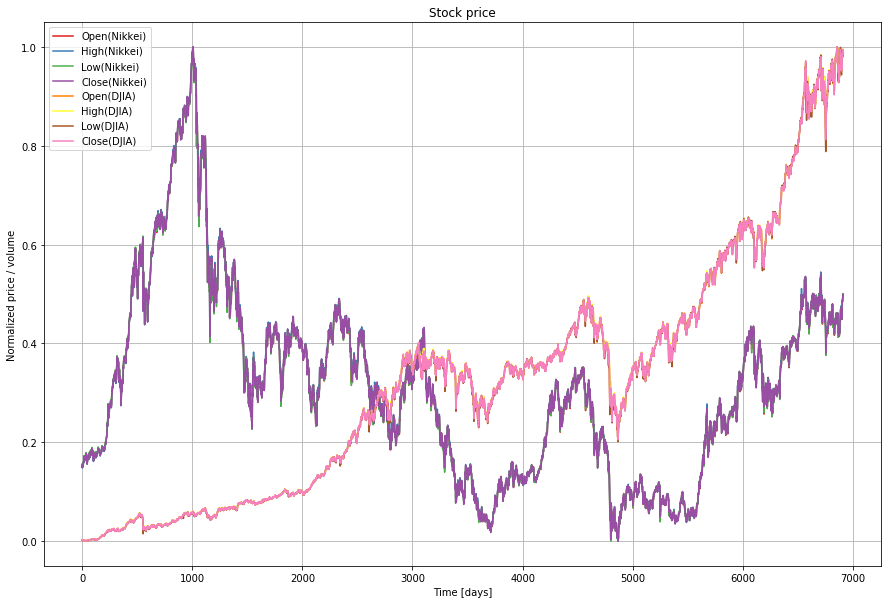

In [12]:
# plot graph before train

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
for i, col in enumerate(event_col):
    plt.plot(df_norm[col], color=color_palette(i), label=col)
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend()
plt.show()

In [13]:
start = 0
for i in range(df.shape[0]) :
    if df.loc[i]['Close(DJIA)'] >= df.loc[i]['Close(Nikkei)'] :
        start = i
        break
print(start)
df_2 = df[start:]
df_2

2638


,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
2638,0.258003,0.256758,0.237947,0.243070,0.252139,0.251625,0.248385,0.247049
2639,0.258003,0.256758,0.237947,0.243070,0.247315,0.248459,0.247263,0.245836
2640,0.247327,0.270863,0.249590,0.258785,0.246054,0.247600,0.247225,0.246570
2641,0.243875,0.243346,0.235396,0.242311,0.251280,0.255440,0.252319,0.255637
2642,0.244138,0.256102,0.246399,0.257487,0.255874,0.256852,0.255978,0.255342
...,...,...,...,...,...,...,...,...
6906,0.488358,0.488062,0.485756,0.488699,0.983626,0.983267,0.980601,0.979176
6907,0.491674,0.492212,0.493498,0.492630,0.979626,0.986467,0.982577,0.985018
6908,0.495723,0.495829,0.497464,0.496292,0.990036,0.992232,0.993125,0.989362
6909,0.498747,0.499351,0.500755,0.499646,0.991939,0.993703,0.991581,0.993776


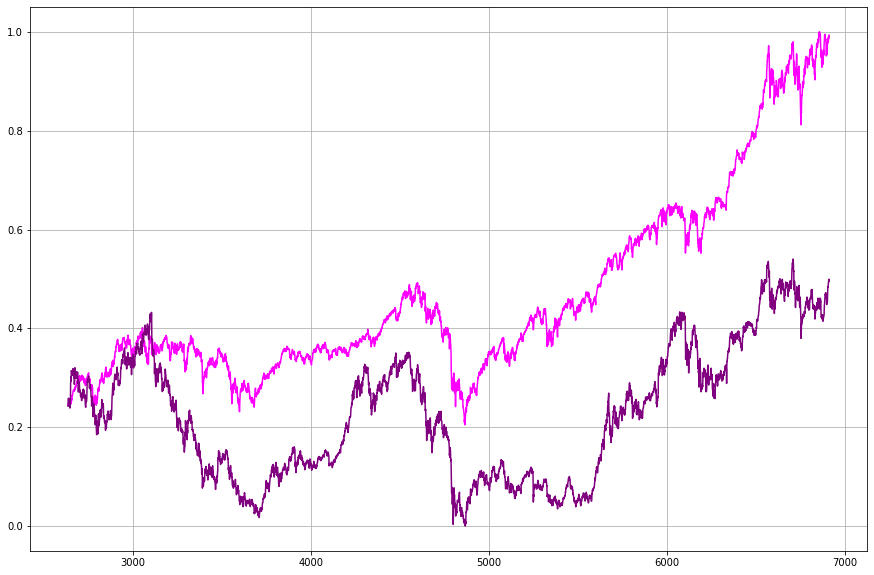

In [14]:
# plot graph after 2 graph sync

# !set color in graph
# color_palette = ...
plt.figure(figsize=(15, 10))
plt.grid()
color_palette = plt.get_cmap('Set1')
plt.plot(df_2['Close(DJIA)'],color='magenta')
plt.plot(df_2['Close(Nikkei)'],color='purple')

In [15]:
# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_2_norm = normalize_data(df_2, event_col)

# split train, val, test data

x2_train, y2_train, x2_val, y2_val, x2_test, y2_test = load_data(df_2_norm, seq_len)

print('x_train.shape = ', x2_train.shape)
print('y_train.shape = ', y2_train.shape)
print('x_val.shape = ', x2_val.shape)
print('y_val.shape = ', y2_val.shape)
print('x_test.shape = ', x2_test.shape)
print('y_test.shape = ', y2_test.shape)

x_train.shape =  (3403, 19, 8)
y_train.shape =  (3403, 8)
x_val.shape =  (425, 19, 8)
y_val.shape =  (425, 8)
x_test.shape =  (425, 19, 8)
y_test.shape =  (425, 8)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [16]:
df_2_norm

,Open(Nikkei),High(Nikkei),Low(Nikkei),Close(Nikkei),Open(DJIA),High(DJIA),Low(DJIA),Close(DJIA)
2638,0.474720,0.471511,0.439808,0.449848,0.061221,0.051805,0.058767,0.052873
2639,0.474720,0.471511,0.439808,0.449848,0.055165,0.047793,0.057362,0.051347
2640,0.455077,0.497415,0.461328,0.478932,0.053581,0.046705,0.057315,0.052270
2641,0.448725,0.446881,0.435092,0.448443,0.060142,0.056639,0.063694,0.063675
2642,0.449209,0.470308,0.455429,0.476530,0.065909,0.058427,0.068276,0.063304
...,...,...,...,...,...,...,...,...
6906,0.898570,0.896280,0.897844,0.904434,0.979446,0.978799,0.975707,0.973806
6907,0.904672,0.903900,0.912153,0.911707,0.974425,0.982854,0.978181,0.981155
6908,0.912122,0.910542,0.919483,0.918484,0.987492,0.990158,0.991391,0.986619
6909,0.917686,0.917011,0.925567,0.924691,0.989882,0.992022,0.989458,0.992170


# Training

In [17]:
# hyperparameter 
batch_size = 1000
epochs = 500

# set up callback_list
weight_path_model = "saved_model/model_djia_support_nikkei_sync_period.h5"
tensorboard_path = 'Graph/djia_support_nikkei_sync_period'
callbacks_list_model = [
    TensorBoard(log_dir=tensorboard_path),
    ModelCheckpoint(
            weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=1e-9)
]

In [18]:
K.clear_session()

def get_bi_gru():
    
    input1 = Input(shape=(19,8,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(8,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(lr=1e-5, decay=1e-4),
                loss='mse',
                metrics=['mse'])   
    
    return model

model = get_bi_gru()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 8)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 512)           542720    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
gru (GRU)                    (None, 128)               246144    
_______________________

# Experiment and Result

In [19]:
history = model.fit(x_train, y_train, epochs=epochs , callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) 

Train on 5513 samples, validate on 689 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/500
5000/5513 [==========================>...] - ETA: 1s - loss: 2.2621 - mean_squared_error: 2.2621
Epoch 00001: val_loss improved from inf to 0.18841, saving model to saved_model/model_djia_support_nikkei_sync_period.h5
5513/5513 [==============================] - 22s 4ms/sample - loss: 2.2395 - mean_squared_error: 2.2395 - val_loss: 0.1884 - val_mean_squared_error: 0.1884
Epoch 2/500
5000/5513 [==========================>...] - ETA: 1s - loss: 1.7453 - mean_squared_error: 1.7453
Epoch 00002: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 1.7288 - mean_squared_error: 1.7288 - val_loss: 0.1885 - val_mean_squared_error: 0.1885
Epoch 3/500
5000/5513 [==========================>...] - ETA: 1s - loss: 1.3841 - mean_squared_error: 1.3841
Epoch 00003: val_loss did not improve from 0.188

Epoch 26/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.6242 - mean_squared_error: 0.6242
Epoch 00026: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.6257 - mean_squared_error: 0.6257 - val_loss: 0.2365 - val_mean_squared_error: 0.2365
Epoch 27/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.6392 - mean_squared_error: 0.6392
Epoch 00027: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.6414 - mean_squared_error: 0.6414 - val_loss: 0.2413 - val_mean_squared_error: 0.2413
Epoch 28/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.6205 - mean_squared_error: 0.6205
Epoch 00028: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.6178 - mean_squared_error: 0.6178 - val_loss: 0.2462 - val_mean_squared_error: 0.2462
Epoch 29/500
5000/5513 [=========================

Epoch 52/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5810 - mean_squared_error: 0.5810
Epoch 00052: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5811 - mean_squared_error: 0.5811 - val_loss: 0.4236 - val_mean_squared_error: 0.4236
Epoch 53/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5718 - mean_squared_error: 0.5718
Epoch 00053: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5715 - mean_squared_error: 0.5715 - val_loss: 0.4315 - val_mean_squared_error: 0.4315
Epoch 54/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5697 - mean_squared_error: 0.5697
Epoch 00054: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5710 - mean_squared_error: 0.5710 - val_loss: 0.4393 - val_mean_squared_error: 0.4393
Epoch 55/500
5000/5513 [=========================

Epoch 78/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5598 - mean_squared_error: 0.5598
Epoch 00078: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5603 - mean_squared_error: 0.5603 - val_loss: 0.5506 - val_mean_squared_error: 0.5506
Epoch 79/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5556 - mean_squared_error: 0.5556
Epoch 00079: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5550 - mean_squared_error: 0.5550 - val_loss: 0.5510 - val_mean_squared_error: 0.5510
Epoch 80/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5558 - mean_squared_error: 0.5558
Epoch 00080: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5582 - mean_squared_error: 0.5582 - val_loss: 0.5510 - val_mean_squared_error: 0.5510
Epoch 81/500
5000/5513 [=========================

Epoch 104/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5602 - mean_squared_error: 0.5602
Epoch 00104: val_loss did not improve from 0.18841
5513/5513 [==============================] - 16s 3ms/sample - loss: 0.5627 - mean_squared_error: 0.5627 - val_loss: 0.4523 - val_mean_squared_error: 0.4523
Epoch 105/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5608 - mean_squared_error: 0.5608
Epoch 00105: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5599 - mean_squared_error: 0.5599 - val_loss: 0.4471 - val_mean_squared_error: 0.4471
Epoch 106/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5461 - mean_squared_error: 0.5461
Epoch 00106: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5466 - mean_squared_error: 0.5466 - val_loss: 0.4421 - val_mean_squared_error: 0.4421
Epoch 107/500
5000/5513 [=====================

Epoch 130/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5394 - mean_squared_error: 0.5394
Epoch 00130: val_loss did not improve from 0.18841
5513/5513 [==============================] - 16s 3ms/sample - loss: 0.5394 - mean_squared_error: 0.5394 - val_loss: 0.4707 - val_mean_squared_error: 0.4707
Epoch 131/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5493 - mean_squared_error: 0.5493
Epoch 00131: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5479 - mean_squared_error: 0.5479 - val_loss: 0.4780 - val_mean_squared_error: 0.4780
Epoch 132/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5512 - mean_squared_error: 0.5512
Epoch 00132: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5495 - mean_squared_error: 0.5495 - val_loss: 0.4864 - val_mean_squared_error: 0.4864
Epoch 133/500
5000/5513 [=====================

Epoch 156/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5423 - mean_squared_error: 0.5423
Epoch 00156: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5406 - mean_squared_error: 0.5406 - val_loss: 0.6724 - val_mean_squared_error: 0.6724
Epoch 157/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5529 - mean_squared_error: 0.5529
Epoch 00157: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5505 - mean_squared_error: 0.5505 - val_loss: 0.6780 - val_mean_squared_error: 0.6780
Epoch 158/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5494 - mean_squared_error: 0.5494
Epoch 00158: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5495 - mean_squared_error: 0.5495 - val_loss: 0.6836 - val_mean_squared_error: 0.6836
Epoch 159/500
5000/5513 [=====================

Epoch 182/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5395 - mean_squared_error: 0.5395
Epoch 00182: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5402 - mean_squared_error: 0.5402 - val_loss: 0.7612 - val_mean_squared_error: 0.7612
Epoch 183/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5665 - mean_squared_error: 0.5665
Epoch 00183: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5664 - mean_squared_error: 0.5664 - val_loss: 0.7617 - val_mean_squared_error: 0.7617
Epoch 184/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5503 - mean_squared_error: 0.5503
Epoch 00184: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5502 - mean_squared_error: 0.5502 - val_loss: 0.7632 - val_mean_squared_error: 0.7632
Epoch 185/500
5000/5513 [=====================

Epoch 208/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5424 - mean_squared_error: 0.5424
Epoch 00208: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5419 - mean_squared_error: 0.5419 - val_loss: 0.7833 - val_mean_squared_error: 0.7833
Epoch 209/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5535 - mean_squared_error: 0.5535
Epoch 00209: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5535 - mean_squared_error: 0.5535 - val_loss: 0.7833 - val_mean_squared_error: 0.7833
Epoch 210/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5445 - mean_squared_error: 0.5445
Epoch 00210: val_loss did not improve from 0.18841
5513/5513 [==============================] - 14s 3ms/sample - loss: 0.5423 - mean_squared_error: 0.5423 - val_loss: 0.7834 - val_mean_squared_error: 0.7834
Epoch 211/500
5000/5513 [=====================

Epoch 234/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5466 - mean_squared_error: 0.5466
Epoch 00234: val_loss did not improve from 0.18841
5513/5513 [==============================] - 15s 3ms/sample - loss: 0.5438 - mean_squared_error: 0.5438 - val_loss: 0.7862 - val_mean_squared_error: 0.7862
Epoch 235/500
5000/5513 [==========================>...] - ETA: 1s - loss: 0.5488 - mean_squared_error: 0.5488
Epoch 00235: val_loss did not improve from 0.18841
5513/5513 [==============================] - 13s 2ms/sample - loss: 0.5480 - mean_squared_error: 0.5480 - val_loss: 0.7857 - val_mean_squared_error: 0.7857
Epoch 236/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5419 - mean_squared_error: 0.5419
Epoch 00236: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5437 - mean_squared_error: 0.5437 - val_loss: 0.7855 - val_mean_squared_error: 0.7855
Epoch 237/500
5000/5513 [=====================

Epoch 260/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5438 - mean_squared_error: 0.5438
Epoch 00260: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5452 - mean_squared_error: 0.5452 - val_loss: 0.7839 - val_mean_squared_error: 0.7839
Epoch 261/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5426 - mean_squared_error: 0.5426
Epoch 00261: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5432 - mean_squared_error: 0.5432 - val_loss: 0.7837 - val_mean_squared_error: 0.7837
Epoch 262/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5457 - mean_squared_error: 0.5457
Epoch 00262: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5449 - mean_squared_error: 0.5449 - val_loss: 0.7833 - val_mean_squared_error: 0.7833
Epoch 263/500
5000/5513 [=======================

Epoch 286/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5517 - mean_squared_error: 0.5517
Epoch 00286: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5489 - mean_squared_error: 0.5489 - val_loss: 0.7869 - val_mean_squared_error: 0.7869
Epoch 287/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5434 - mean_squared_error: 0.5434
Epoch 00287: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5432 - mean_squared_error: 0.5432 - val_loss: 0.7871 - val_mean_squared_error: 0.7871
Epoch 288/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5495 - mean_squared_error: 0.5495
Epoch 00288: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5491 - mean_squared_error: 0.5491 - val_loss: 0.7869 - val_mean_squared_error: 0.7869
Epoch 289/500
5000/5513 [=====================

Epoch 312/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5520 - mean_squared_error: 0.5520
Epoch 00312: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5507 - mean_squared_error: 0.5507 - val_loss: 0.7872 - val_mean_squared_error: 0.7872
Epoch 313/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5529 - mean_squared_error: 0.5529
Epoch 00313: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5522 - mean_squared_error: 0.5522 - val_loss: 0.7873 - val_mean_squared_error: 0.7873
Epoch 314/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5631 - mean_squared_error: 0.5631
Epoch 00314: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5598 - mean_squared_error: 0.5598 - val_loss: 0.7862 - val_mean_squared_error: 0.7862
Epoch 315/500
5000/5513 [=====================

Epoch 338/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5501 - mean_squared_error: 0.5501
Epoch 00338: val_loss did not improve from 0.18841
5513/5513 [==============================] - 11s 2ms/sample - loss: 0.5480 - mean_squared_error: 0.5480 - val_loss: 0.7856 - val_mean_squared_error: 0.7856
Epoch 339/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5504 - mean_squared_error: 0.5504
Epoch 00339: val_loss did not improve from 0.18841
5513/5513 [==============================] - 11s 2ms/sample - loss: 0.5513 - mean_squared_error: 0.5513 - val_loss: 0.7859 - val_mean_squared_error: 0.7859
Epoch 340/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5541 - mean_squared_error: 0.5541
Epoch 00340: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5546 - mean_squared_error: 0.5546 - val_loss: 0.7860 - val_mean_squared_error: 0.7860
Epoch 341/500
5000/5513 [======================

Epoch 364/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5457 - mean_squared_error: 0.5457
Epoch 00364: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5455 - mean_squared_error: 0.5455 - val_loss: 0.7876 - val_mean_squared_error: 0.7876
Epoch 365/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5573 - mean_squared_error: 0.5573
Epoch 00365: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5551 - mean_squared_error: 0.5551 - val_loss: 0.7875 - val_mean_squared_error: 0.7875
Epoch 366/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5454 - mean_squared_error: 0.5454
Epoch 00366: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5449 - mean_squared_error: 0.5449 - val_loss: 0.7873 - val_mean_squared_error: 0.7873
Epoch 367/500
5000/5513 [=====================

Epoch 390/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5420 - mean_squared_error: 0.5420
Epoch 00390: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5416 - mean_squared_error: 0.5416 - val_loss: 0.7861 - val_mean_squared_error: 0.7861
Epoch 391/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5454 - mean_squared_error: 0.5454
Epoch 00391: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5474 - mean_squared_error: 0.5474 - val_loss: 0.7859 - val_mean_squared_error: 0.7859
Epoch 392/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5507 - mean_squared_error: 0.5507
Epoch 00392: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5489 - mean_squared_error: 0.5489 - val_loss: 0.7857 - val_mean_squared_error: 0.7857
Epoch 393/500
5000/5513 [=====================

Epoch 416/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5469 - mean_squared_error: 0.5469
Epoch 00416: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5480 - mean_squared_error: 0.5480 - val_loss: 0.7852 - val_mean_squared_error: 0.7852
Epoch 417/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5524 - mean_squared_error: 0.5524
Epoch 00417: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5503 - mean_squared_error: 0.5503 - val_loss: 0.7856 - val_mean_squared_error: 0.7856
Epoch 418/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5515 - mean_squared_error: 0.5515
Epoch 00418: val_loss did not improve from 0.18841
5513/5513 [==============================] - 10s 2ms/sample - loss: 0.5510 - mean_squared_error: 0.5510 - val_loss: 0.7852 - val_mean_squared_error: 0.7852
Epoch 419/500
5000/5513 [=====================

Epoch 442/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5517 - mean_squared_error: 0.5517
Epoch 00442: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5515 - mean_squared_error: 0.5515 - val_loss: 0.7866 - val_mean_squared_error: 0.7866
Epoch 443/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5468 - mean_squared_error: 0.5468
Epoch 00443: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5473 - mean_squared_error: 0.5473 - val_loss: 0.7862 - val_mean_squared_error: 0.7862
Epoch 444/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5512 - mean_squared_error: 0.5512
Epoch 00444: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5511 - mean_squared_error: 0.5511 - val_loss: 0.7861 - val_mean_squared_error: 0.7861
Epoch 445/500
5000/5513 [========================

Epoch 468/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5454 - mean_squared_error: 0.5454
Epoch 00468: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5456 - mean_squared_error: 0.5456 - val_loss: 0.7847 - val_mean_squared_error: 0.7847
Epoch 469/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5446 - mean_squared_error: 0.5446
Epoch 00469: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5459 - mean_squared_error: 0.5459 - val_loss: 0.7853 - val_mean_squared_error: 0.7853
Epoch 470/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5508 - mean_squared_error: 0.5508
Epoch 00470: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5501 - mean_squared_error: 0.5501 - val_loss: 0.7849 - val_mean_squared_error: 0.7849
Epoch 471/500
5000/5513 [========================

Epoch 494/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5465 - mean_squared_error: 0.5465
Epoch 00494: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5497 - mean_squared_error: 0.5497 - val_loss: 0.7864 - val_mean_squared_error: 0.7864
Epoch 495/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5474 - mean_squared_error: 0.5474
Epoch 00495: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5481 - mean_squared_error: 0.5481 - val_loss: 0.7862 - val_mean_squared_error: 0.7862
Epoch 496/500
5000/5513 [==========================>...] - ETA: 0s - loss: 0.5420 - mean_squared_error: 0.5420
Epoch 00496: val_loss did not improve from 0.18841
5513/5513 [==============================] - 9s 2ms/sample - loss: 0.5430 - mean_squared_error: 0.5430 - val_loss: 0.7866 - val_mean_squared_error: 0.7866
Epoch 497/500
5000/5513 [========================

In [20]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error', 'lr'])


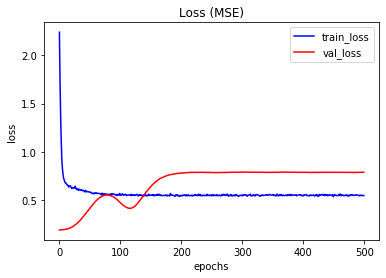

In [21]:
plt.title("Loss (MSE)")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.savefig('loss_support_sync_data.png')

In [27]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [28]:
#fix!
def plot_compare(x, event_col):
#     Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    Col = dict()
    count = 0
    for i, col in enumerate(event_col):
        Col[col] = i
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices :' + x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



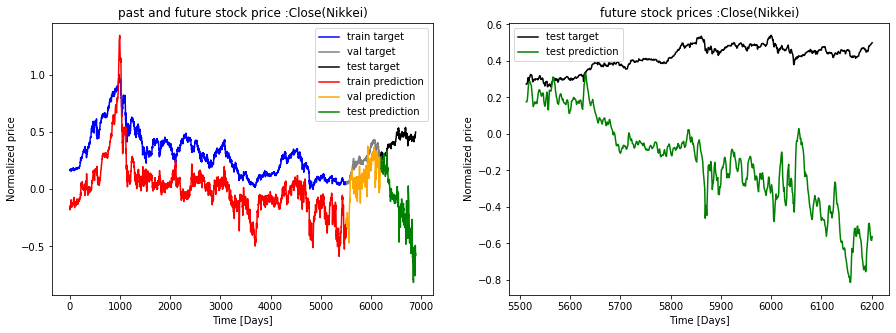

In [29]:
plot_compare('Close(Nikkei)', event_col)

In [30]:
model.evaluate(x_test,y_test)

689/689 [==============================] - 0s 480us/sample - loss: 12.3951 - mean_squared_error: 12.3951


[12.395078650752762, 12.395079]

In [31]:
model.evaluate(x_val,y_val)

689/689 [==============================] - 0s 545us/sample - loss: 0.7867 - mean_squared_error: 0.7867


[0.7866958777686508, 0.78669584]

In [32]:
model.evaluate(x_train,y_train)

5513/5513 [==============================] - 3s 480us/sample - loss: 0.0806 - mean_squared_error: 0.0806


[0.08058590460862608, 0.080585875]